In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## **Data Processing**

In [ ]:
#Import portfolio equity data from spreadsheet in Google Drive
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQT9ZvlCv6SgOafgV_VyOVrqbn0F5O--Ihh1ZR7Gjd4quqsGAeJEGIXhdaFSGfngl4eKKPRqIDm5hpj/pub?gid=1159456086&single=true&output=csv') #last 2 year
df.head()

,Date,Fama French 5 factor,"MPT ETF allocation (SPY, QQQ, TLT, GLD)",Market Bond Rotation,Tiingo News NLP
0,1546318800,131094.205,135836.36,100000.0000,100000.0000
1,1546441200,131094.205,135834.99,100000.0000,100000.0000
2,1546491600,131175.825,136169.87,99953.3565,100000.0000
3,1546578000,133566.125,133827.45,100849.1154,100000.0000
4,1546664400,133325.505,133827.45,99719.1453,102179.7578


In [ ]:
#converting unix timestamp into regular date format
df['Date']= pd.to_datetime(df['Date'], unit='s').dt.date
df.head()

,Date,Fama French 5 factor,"MPT ETF allocation (SPY, QQQ, TLT, GLD)",Market Bond Rotation,Tiingo News NLP
0,2019-01-01,131094.205,135836.36,100000.0000,100000.0000
1,2019-01-02,131094.205,135834.99,100000.0000,100000.0000
2,2019-01-03,131175.825,136169.87,99953.3565,100000.0000
3,2019-01-04,133566.125,133827.45,100849.1154,100000.0000
4,2019-01-05,133325.505,133827.45,99719.1453,102179.7578


In [ ]:
#setting index to 'Date' column
df = df.set_index(pd.to_datetime(df['Date']))
df = df.drop('Date', axis=1)
df.head()

,Fama French 5 factor,"MPT ETF allocation (SPY, QQQ, TLT, GLD)",Market Bond Rotation,Tiingo News NLP
Date,,,,
2019-01-01,131094.205,135836.36,100000.0000,100000.0000
2019-01-02,131094.205,135834.99,100000.0000,100000.0000
2019-01-03,131175.825,136169.87,99953.3565,100000.0000
2019-01-04,133566.125,133827.45,100849.1154,100000.0000
2019-01-05,133325.505,133827.45,99719.1453,102179.7578


## **Co-variance Matrix of assets/strategies**



In [ ]:
#Co-variance matrix
# Log of percentage change
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()

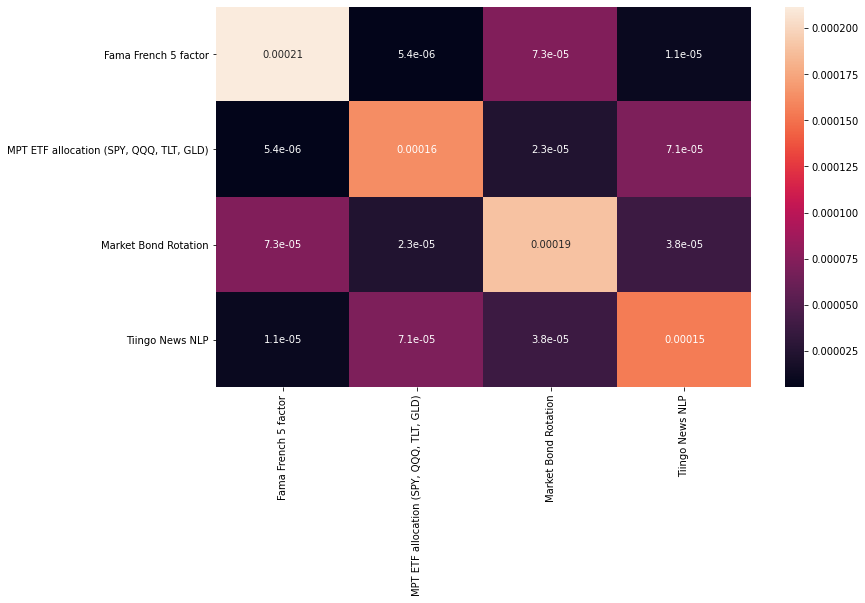

In [ ]:
plt.figure(figsize=(12,7))
cov_matrix_plot = sns.heatmap(cov_matrix, annot=True)

## **Correlation Matrix of Assets/Strategies**

In [ ]:
#Correlation matrix
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()

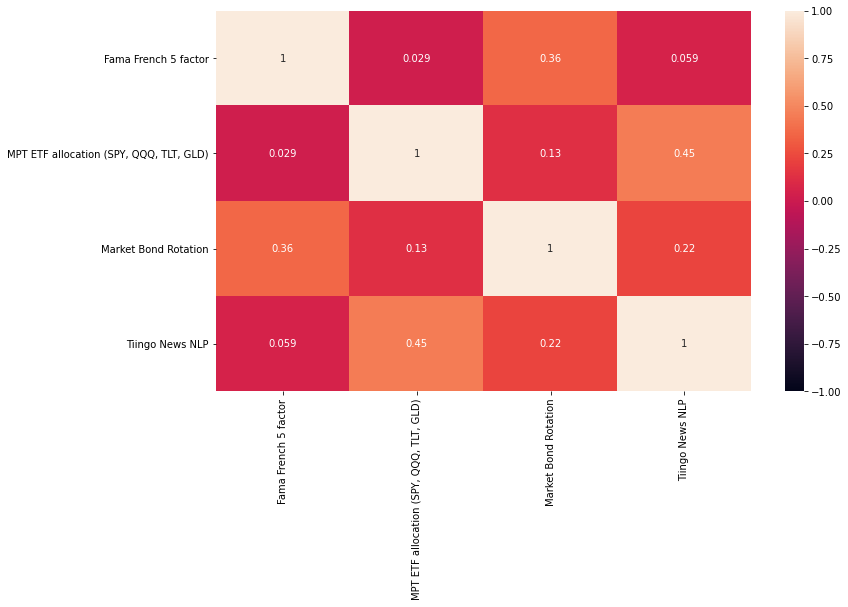

In [ ]:
plt.figure(figsize=(12,7))
corr_matrix_plot = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)

## **Annual Returns**

In [ ]:
# Yearly returns for individual assets/strategies
ind_er = df.resample('Y').last().pct_change().mean() #for more than 1 year
ind_er

Fama French 5 factor                       0.426970
MPT ETF allocation (SPY, QQQ, TLT, GLD)    0.325569
Market Bond Rotation                       1.178451
Tiingo News NLP                            0.567022
dtype: float64

## **Volatility (Standard Deviation)**

In [ ]:
# Converting daily standard deviation to annual standard deviation
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

Fama French 5 factor                       0.229962
MPT ETF allocation (SPY, QQQ, TLT, GLD)    0.201672
Market Bond Rotation                       0.217444
Tiingo News NLP                            0.196713
dtype: float64

## **Comparison of Returns & Volatility of Assets/Strategies**

In [ ]:
# Creating a table for visualising returns and volatility of assets/strategies
assets = pd.concat([ind_er, ann_sd], axis=1) 
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
Fama French 5 factor,0.426970,0.229962
"MPT ETF allocation (SPY, QQQ, TLT, GLD)",0.325569,0.201672
Market Bond Rotation,1.178451,0.217444
Tiingo News NLP,0.567022,0.196713


## **Plotting Efficient Frontier**

In [ ]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset/strategy weights

num_assets = len(df.columns)
num_portfolios = 100000 #number of portfolios to plot 

In [ ]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its weights 
    p_ret.append(returns)
    
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [ ]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [ ]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the number of portfolios(num_portfolios) created

,Returns,Volatility,Fama French 5 factor weight,"MPT ETF allocation (SPY, QQQ, TLT, GLD) weight",Market Bond Rotation weight,Tiingo News NLP weight
0,0.654317,0.135658,0.173772,0.256603,0.283908,0.285716
1,0.725710,0.146787,0.003537,0.357346,0.401462,0.237656
2,0.648498,0.145486,0.023113,0.434159,0.309998,0.232730
3,0.702793,0.163172,0.478639,0.086600,0.365888,0.068873
4,0.759950,0.144844,0.053681,0.280085,0.438437,0.227798


Text(0, 0.5, 'Returns')

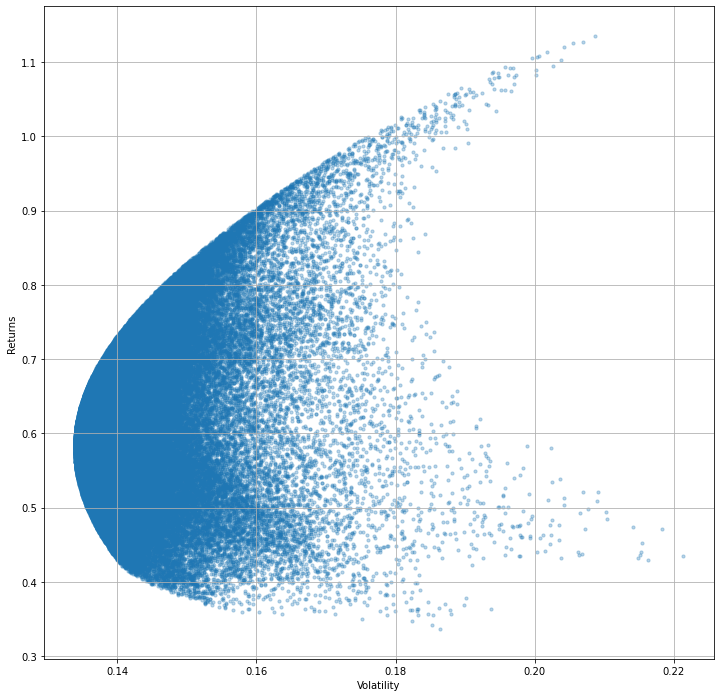

In [ ]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[12,12])
plt.xlabel('Volatility')
plt.ylabel('Returns')

## **Getting Weights for Lowest Volatility**

In [ ]:
#Getting parameter/weights of the point with minimum volatility
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns                                           0.581307
Volatility                                        0.133866
Fama French 5 factor weight                       0.251055
MPT ETF allocation (SPY, QQQ, TLT, GLD) weight    0.288478
Market Bond Rotation weight                       0.194789
Tiingo News NLP weight                            0.265678
Name: 85326, dtype: float64

In [ ]:
assets

,Returns,Volatility
Fama French 5 factor,0.426970,0.229962
"MPT ETF allocation (SPY, QQQ, TLT, GLD)",0.325569,0.201672
Market Bond Rotation,1.178451,0.217444
Tiingo News NLP,0.567022,0.196713


In [ ]:
#Sharpe Ratio of minimally volatile portfolio
sharpe_ratio_min_vol = min_vol_port[0] / min_vol_port[1]
sharpe_ratio_min_vol

4.342447656567645

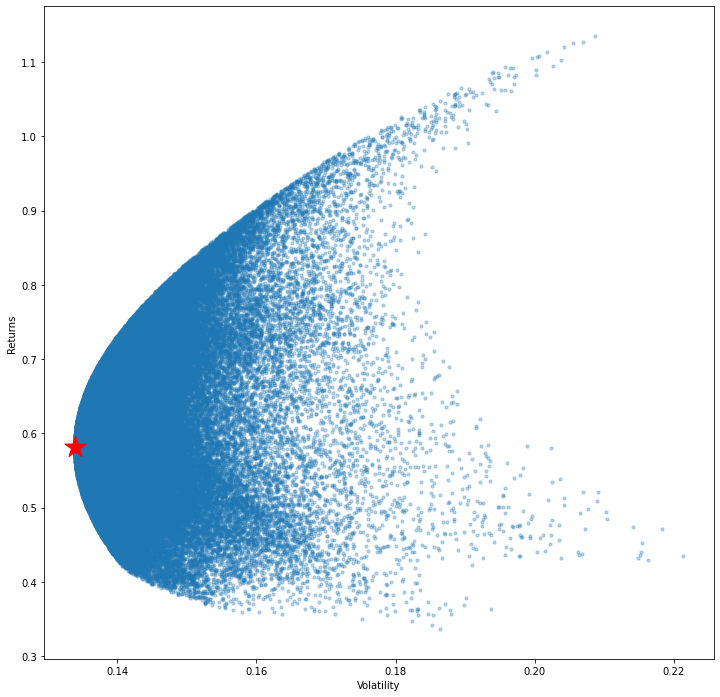

In [ ]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[12,12])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

## **Getting Weights for Highest Sharpe Ratio**

In [ ]:
# Finding the optimal portfolio (i.e. Highest Sharpe Ratio)

# risk factor(risk-free rate)
rf = 0.0161  #1.61% Average return of Singapore Savings Bonds over 10 years https://www.mas.gov.sg/bonds-and-bills/Singapore-Savings-Bonds

optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns                                           0.993919
Volatility                                        0.174756
Fama French 5 factor weight                       0.014106
MPT ETF allocation (SPY, QQQ, TLT, GLD) weight    0.019109
Market Bond Rotation weight                       0.708972
Tiingo News NLP weight                            0.257813
Name: 69308, dtype: float64

In [ ]:
assets

,Returns,Volatility
Fama French 5 factor,0.426970,0.229962
"MPT ETF allocation (SPY, QQQ, TLT, GLD)",0.325569,0.201672
Market Bond Rotation,1.178451,0.217444
Tiingo News NLP,0.567022,0.196713


In [ ]:
#Sharpe Ratio of Optimally risky portfolio
sharpe_ratio_risky = optimal_risky_port[0] / optimal_risky_port[1]
sharpe_ratio_risky

5.687460871432692

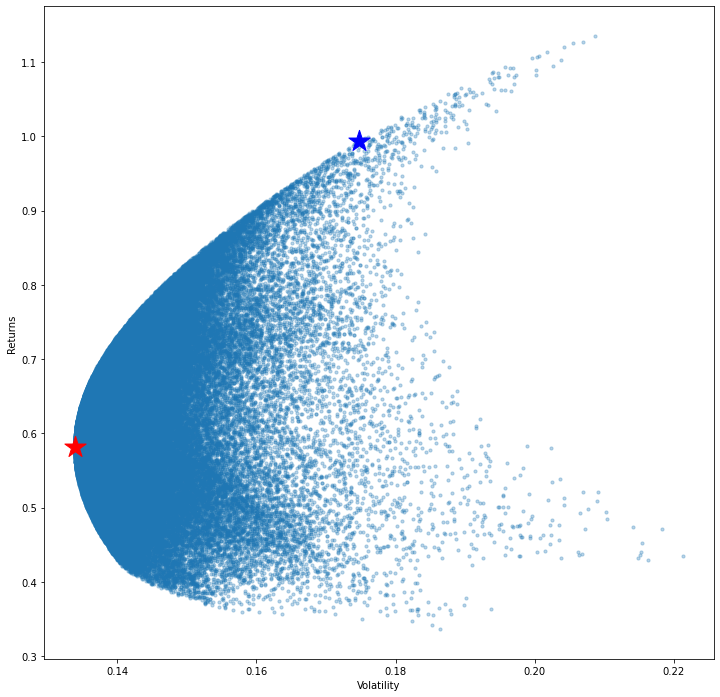

In [ ]:
# Plotting optimal portfolio (Blue Star)
plt.subplots(figsize=(12, 12))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='b', marker='*', s=500)

In [ ]:
from google.colab import drive
drive.mount('/drive')
portfolios.to_excel('/drive/My Drive/SGUS Fintech Algo-trading BI Project/Working Folders/Phase 2 Algo-Trading/MPT/MPT Python SGUS Project 2 year random weights Optimized High Risk.xlsx')

Mounted at /drive


In [ ]:
#https://docs.google.com/spreadsheets/d/e/2PACX-1vQ4hlgf4w5X_aL3oJufF-CZz2yS6vu9E99MHKMyGF9QZv2nsi8_5RNKKY4muTuUQg/pubhtml